<a href="https://colab.research.google.com/github/athiragp/Stock-price-prediction/blob/main/bajaj_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


# Load and clean the dataset
file_path = '/content/BAJFINANCE.csv'
data = pd.read_csv(file_path)

# Remove rows with null values
data_cleaned = data.dropna()

# Calculating rolling mean and standard deviation
lag_features = ['High', 'Low', 'Volume', 'Turnover', 'Trades']
for feature in lag_features:
    for window in [3, 7]:
        data_cleaned[f'{feature}_mean_{window}'] = data_cleaned[feature].rolling(window=window).mean()
        data_cleaned[f'{feature}_std_{window}'] = data_cleaned[feature].rolling(window=window).std()

# Remove rows with NaN values in new columns
data_cleaned_no_nan = data_cleaned.dropna()

# Set 'Date' as index
data_cleaned_no_nan['Date'] = pd.to_datetime(data_cleaned_no_nan['Date'])
data_cleaned_no_nan.set_index('Date', inplace=True)

# Split the data into training and test sets (80/20 split)
split_index = int(len(data_cleaned_no_nan) * 0.8)
train_data = data_cleaned_no_nan.iloc[:split_index]
test_data = data_cleaned_no_nan.iloc[split_index:]


In [ ]:
!pip install tensorflow

In [3]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Assuming train_data and test_data are already defined and include the target variable 'VWAP'

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_data['VWAP'].values.reshape(-1, 1))

# Convert time series data to supervised learning problem
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 100
X_train, y_train = create_dataset(scaled_train, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Define the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1)

# Predictions and Performance Evaluation
# (Similar steps will be required for test data, including scaling and reshaping)


Epoch 1/100
27/27 [==============================] - 6s 106ms/step - loss: 0.0132
Epoch 2/100
27/27 [==============================] - 3s 116ms/step - loss: 0.0019
Epoch 3/100
27/27 [==============================] - 3s 124ms/step - loss: 0.0026
Epoch 4/100
27/27 [==============================] - 4s 157ms/step - loss: 0.0014
Epoch 5/100
27/27 [==============================] - 2s 74ms/step - loss: 0.0016
Epoch 6/100
27/27 [==============================] - 2s 61ms/step - loss: 0.0013
Epoch 7/100
27/27 [==============================] - 2s 61ms/step - loss: 0.0013
Epoch 8/100
27/27 [==============================] - 2s 62ms/step - loss: 0.0011
Epoch 9/100
27/27 [==============================] - 2s 62ms/step - loss: 0.0011
Epoch 10/100
27/27 [==============================] - 2s 84ms/step - loss: 9.1098e-04
Epoch 11/100
27/27 [==============================] - 2s 73ms/step - loss: 9.5770e-04
Epoch 12/100
27/27 [==============================] - 2s 62ms/step - loss: 7.3218e-04
Epoch 13/

12/12 [==============================] - 1s 14ms/step


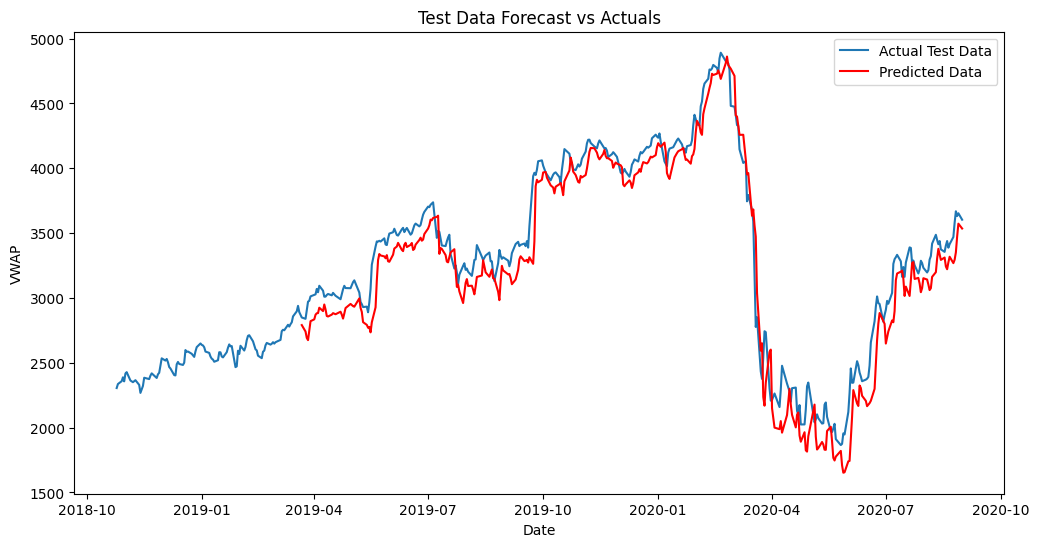

In [4]:
# Continue from the previous LSTM training code...
import matplotlib.pyplot as plt

# Preprocess the test data
scaled_test = scaler.transform(test_data['VWAP'].values.reshape(-1, 1))
X_test, y_test = create_dataset(scaled_test, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Make predictions
predicted = model.predict(X_test)

# Inverse transform the predictions to original scale
predicted = scaler.inverse_transform(predicted)



# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['VWAP'], label='Actual Test Data')
plt.plot(test_data.index[time_step + 1:], predicted, label='Predicted Data', color='red')
plt.title('Test Data Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('VWAP')
plt.legend()
plt.show()


In [5]:
#Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Actual values (considering the offset due to time_step)
actual = test_data['VWAP'].values[time_step + 1:]

# Flatten the predicted values array
predicted_flat = predicted.flatten()

# Mean Absolute Error (MAE)
mae = mean_absolute_error(actual, predicted_flat)
print(f'Mean Absolute Error (MAE): {mae}')

# Mean Squared Error (MSE)
mse = mean_squared_error(actual, predicted_flat)
print(f'Mean Squared Error (MSE): {mse}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual - predicted_flat) / actual)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')


Mean Absolute Error (MAE): 154.64266369766065
Mean Squared Error (MSE): 37398.40905602204
Root Mean Squared Error (RMSE): 193.38668272666047
Mean Absolute Percentage Error (MAPE): 5.0136823522517%
